### This notebook is for additional carbonate chemistry evaluations, including Puget Sound. 
#### Observation data were obtained from: https://www.ncei.noaa.gov/access/ocean-carbon-acidification-data-system/oceans/SalishCruise_DataPackage.html and
#### /ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/PI_CARBON_PAPER/MAIN_ANALYSIS/KEY_MODEVAL/Datasets
#### Observation-model matches are from: OA_PugetSound_CarbonateChemModelvsObsMatches20152018_v202111_qualcontrol.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import os
import datetime as dt
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import cmocean
import json
import f90nml
from collections import OrderedDict
from scipy.stats.mstats import gmean
import netCDF4 as nc
from mocsy import mocsy

fs=14
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display



%matplotlib inline

In [2]:
## Bringing in observation-model matches created in OA_PugetSound_CarbonateChemModelvsObsMatches20072024_v202111_qualcontrol_MatchbySalinity.ipynb
df1 = pd.read_csv('CarbonateChemModelvsObsMatches_2007to2010_Eval202111_MatchbySalinity.csv', index_col=0,header=0)

In [3]:
## Bringing in observation-model matches created in OA_PugetSound_CarbonateChemModelvsObsMatches20072024_v202111_qualcontrol_MatchbySalinity.ipynb
df2 = pd.read_csv('CarbonateChemModelvsObsMatches_2011to2014_Eval202111_MatchbySalinity.csv', index_col=0,header=0)

In [4]:
## Bringing in observation-model matches created in OA_PugetSound_CarbonateChemModelvsObsMatches20072024_v202111_qualcontrol_MatchbySalinity.ipynb
df3 = pd.read_csv('CarbonateChemModelvsObsMatches_2015to2016_Eval202111_MatchbySalinity.csv', index_col=0,header=0)

In [5]:
## Bringing in observation-model matches created in OA_PugetSound_CarbonateChemModelvsObsMatches20072024_v202111_qualcontrol_MatchbySalinity.ipynb
df4 = pd.read_csv('CarbonateChemModelvsObsMatches_2017to2019_Eval202111_MatchbySalinity.csv', index_col=0,header=0)

In [6]:
data=pd.concat([df1,df2,df3,df4], axis=0, join='outer')

In [7]:
data.keys()

Index(['Cruise', 'dtUTC', 'Time', 'Lat', 'Lon', 'Z', 'Temp (degC)',
       'Temp (CT degC)', 'Sal (g kg-1)', 'Sal (PSS)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'TA (uM)', 'DIC (uM)', 'TA_FLAG',
       'DIC_FLAG', 'Unnamed: 0', 'ln', 'stn', 'mon', 'day', 'dic', 'alk',
       'OmegaA', 'obs_j', 'obs_i', 'Year', 'Month', 'YMO', 'j', 'i',
       'mod_dissolved_inorganic_carbon', 'mod_total_alkalinity',
       'mod_dissolved_oxygen', 'mod_votemper', 'mod_vosaline',
       'matched_salinity'],
      dtype='object')

### Calculate OmegaA for observation data

In [8]:
DIC = data['DIC (uM)'].to_numpy()
TA = data['TA (uM)'].to_numpy()
Lat = data['Lat'].to_numpy()
Lon = data['Lon'].to_numpy()
Sal = data['Sal (PSS)'].to_numpy()
Temp = data['Temp (degC)'].to_numpy()
P = data['Z'].to_numpy()

In [9]:
ones = np.zeros_like(TA) #should be np.ones_like
DIC_conv=DIC*1e-3   ## to convert from uM to mol/m3  
TA_conv=TA*1e-3   ## to convert from uM to mol/m3
#Temp_insitu=gsw.t_from_CT(Sal,Temp,P)
#Sal_conv=Sal*35/35.16504


In [10]:
response_tup = mocsy.mvars(temp=Temp, sal=Sal, alk=TA_conv, dic=DIC_conv,
                       sil=0.*ones, phos=0.*ones, patm=0.*ones, depth=0.*ones, lat=0.*ones, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH_obs,pco2_obs,fco2,co2_obs,hco3,co3,OmegaA_obs,OmegaC,BetaD,DENis,p,Tis = response_tup


data['pH_obs_mask'] = pH_obs
data['co2_obs_mask'] = (co2_obs * 1e6) / DENis ## need to convert from mol/m3 to µmol/kg
data['pco2_obs_mask'] = pco2_obs ## already in µatm

In [11]:
data['co2_obs_mask'].mean()

443965.8664697481

In [12]:
## Need to mask values > 100
mymaskpH_obs = data['pH_obs_mask'] > 100;
data['pH_obs_mask'] = np.ma.array(data['pH_obs_mask'], mask=mymaskpH_obs)

In [13]:
## Need to mask values > 100
mymaskco2_obs = data['co2_obs_mask'] > 1500;
data['co2_obs_mask'] = np.ma.array(data['co2_obs_mask'], mask=mymaskco2_obs)

In [14]:
## Need to mask values > 100
mymaskpco2_obs = data['pco2_obs_mask'] > 3000;
data['pco2_obs_mask'] = np.ma.array(data['pco2_obs_mask'], mask=mymaskpco2_obs)

In [15]:
data['co2_obs_mask'].mean()

38.499283630199116

In [16]:
data['pco2_obs_mask'].mean()

863.5673460617327

### Calculate OmegaA for model data

In [17]:
DIC_mod = data['mod_dissolved_inorganic_carbon'].to_numpy()
TA_mod = data['mod_total_alkalinity'].to_numpy()
Sal_mod = data['mod_vosaline'].to_numpy()
Temp_mod = data['mod_votemper'].to_numpy()

In [18]:
DIC_mod_conv=DIC_mod*1e-3
TA_mod_conv=TA_mod*1e-3
Temp_insitu_mod=gsw.t_from_CT(Sal_mod,Temp_mod,P)
Sal_conv_mod=Sal_mod*35/35.16504

In [19]:
response_tup = mocsy.mvars(temp=Temp_mod, sal=Sal_conv_mod, alk=TA_mod_conv, dic=DIC_mod_conv,
                       sil=0.*ones, phos=0.*ones, patm=0.*ones, depth=0.*ones, lat=0.*ones, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH_mod,pco2_mod,fco2,co2_mod,hco3,co3,OmegaA_mod,OmegaC,BetaD,DENis,p,Tis = response_tup


data['pH_mod_mask'] = pH_mod
data['co2_mod_mask'] = (co2_mod*1e6)/DENis ## to convert from mol/m3 to µmol/kg
data['pco2_mod_mask'] = pco2_mod ##already in µatm


In [20]:
data['co2_mod_mask'].max()

1000000.0

In [21]:
## Need to mask values > 100
mymaskpH_mod = data['pH_mod_mask'] > 100;
data['pH_mod_mask'] = np.ma.array(data['pH_mod_mask'], mask=mymaskpH_mod)

In [22]:
## Need to mask values > 100
mymaskco2_mod = data['co2_mod_mask'] > 100;
data['co2_mod_mask'] = np.ma.array(data['co2_mod_mask'], mask=mymaskco2_mod)

In [23]:
## Need to mask values > 100
mymaskpco2_mod = data['pco2_mod_mask'] > 3000;
data['pco2_mod_mask'] = np.ma.array(data['pco2_mod_mask'], mask=mymaskpco2_mod)

In [24]:
data['co2_mod_mask'].max()

68.38481362076242

### Plot Observation Locations

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


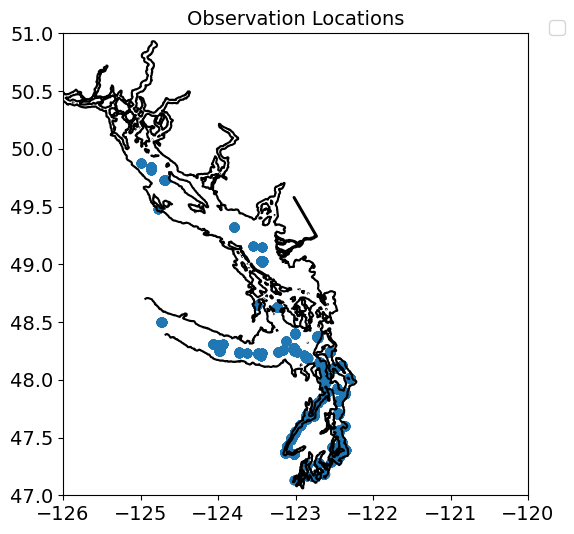

In [25]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_202108.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('teal','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue','lightblue')
#datreg=dict()
#for ind, iregion in enumerate(data.region_name.unique()):
#    datreg[iregion] = data.loc[data.region_name==iregion]
ax.scatter(data['Lon'], data['Lat'],marker='o') #color = colors[ind]
ax.set_ylim(47,51)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -120);
ax.set_title('Observation Locations');
ax.legend(bbox_to_anchor=(1.1, 1.05))

### Create Salish Sea subregions based on Lat/Lon data

In [26]:
## Create a column for subregions within the Salish Sea
data['broadregions']=np.nan

In [27]:
#data.loc[((data['Lat'] >= 49.1) & (data['Lat'] < 49.3) & (data['Lon'] > -123.4)),['broadregions']]='Fraser'

In [28]:
## Select data for only within the Central SoG
data.loc[((data['Lat'] >= 49.1)& (data['Lat'] < 49.5) & (data['Lon'] < -123.4) & (data['Lon'] > -124)),['broadregions']]='Central SoG'

/tmp/ipykernel_3288328/424949213.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Central SoG' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[((data['Lat'] >= 49.1)& (data['Lat'] < 49.5) & (data['Lon'] < -123.4) & (data['Lon'] > -124)),['broadregions']]='Central SoG'


In [29]:
## Select data for only within the Northern SoG
data.loc[((data['Lat'] >= 49.5)& (data['Lat'] < 50) & (data['Lon'] <= -124.5) & (data['Lon'] > -125)),['broadregions']]='Northern SoG'

In [30]:
## Select data for only within the Juan de Fuca Strait
#data.loc[((data['Lat'] >= 48.0) & (data['Lat'] < 49.0) & (data['Lon'] > -123.25)),['broadregions']]='JdF'

data.loc[((data['Lat'] >= 48.2) & (data['Lat'] < 48.55) & (data['Lon'] <= -123.25) & (data['Lon'] > -124.5)),['broadregions']]='JdF'

In [31]:
## Select data for only within the Mixed region
data.loc[((data['Lat'] >= 48.3) & (data['Lat'] < 48.7) & (data['Lon'] <= -122.8) & (data['Lon'] > -123.25)),['broadregions']]='Mixed'

In [32]:
## Select data for only within Puget Sound
#data.loc[((data['Lat'] <= 48.2) & (data['Lon'] <= -122) & (data['Lon'] > -123.5)),['broadregions']]='Puget Sound'

In [33]:
data.loc[((data['Lat'] <= 48.2) & (data['Lat'] > 47.9) & (data['Lon'] <= -122.6) & (data['Lon'] > -123.5)),['broadregions']]='Admiralty Inlet'

In [34]:
data.loc[((data['Lat'] <= 48.2) & (data['Lat'] > 47.9) & (data['Lon'] > -122.6)),['broadregions']]='Whidbey Basin'

In [35]:
data.loc[((data['Lat'] <= 47.9) & (data['Lat'] > 47.35) & (data['Lon'] < -122.65)),['broadregions']]='Hood Canal'

In [36]:
data.loc[((data['Lat'] <= 47.9) & (data['Lat'] > 47.35) & (data['Lon'] > -122.5)),['broadregions']]='Central Basin'

In [37]:
data.loc[((data['Lat'] <= 47.35) & (data['Lon'] < -122.65)),['broadregions']]='South Sound'

In [38]:
data.broadregions.unique()

array(['Central Basin', 'Admiralty Inlet', 'Hood Canal', nan,
       'Whidbey Basin', 'Mixed', 'South Sound', 'JdF', 'Northern SoG',
       'Central SoG'], dtype=object)

In [39]:
data.broadregions

0       Central Basin
1       Central Basin
2       Central Basin
3       Central Basin
4       Central Basin
            ...      
1946              NaN
1947              NaN
1948    Central Basin
1949              NaN
1950    Central Basin
Name: broadregions, Length: 7778, dtype: object

In [40]:
#data=data.dropna(subset=['broadregions']) ## Remove NaN values until I figure out how to classify all subregions

In [41]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
  return np.log10(x+.001)

In [42]:
# define inverse log transform with same shift
def logt_inv(y):
    return 10**y-.001

In [43]:
from matplotlib.colors import LogNorm

In [44]:
#Puget=data.loc[data['broadregions']=='Puget Sound']
CentralSoG=data.loc[data['broadregions']=='Central SoG']
JdF=data.loc[data['broadregions']=='JdF']
Mixed=data.loc[data['broadregions']=='Mixed']
NorthernSoG=data.loc[data['broadregions']=='Northern SoG']
Fraser=data.loc[data['broadregions']=='Fraser']
Admiralty=data.loc[data['broadregions']=='Admiralty Inlet']
Whidbey=data.loc[data['broadregions']=='Whidbey Basin']
CentralBasin=data.loc[data['broadregions']=='Central Basin']
Hood=data.loc[data['broadregions']=='Hood Canal']
SouthSound=data.loc[data['broadregions']=='South Sound']


In [45]:
#Define seasons
#data['Month']=[ii.month for ii in data['dtUTC']]
DJF=JdF.loc[(JdF.Month==12)|(JdF.Month==1)|(JdF.Month==2)]
MAM=JdF.loc[(JdF.Month==3)|(JdF.Month==4)|(JdF.Month==5)]
JJA=JdF.loc[(JdF.Month==6)|(JdF.Month==7)|(JdF.Month==8)]
SON=JdF.loc[(JdF.Month==9)|(JdF.Month==10)|(JdF.Month==11)]

In [46]:
cm1=cmocean.cm.thermal
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_202108.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

In [47]:
## For stats
datreg=dict()
for iregion in data.broadregions.dropna().unique():
    datreg[iregion] = data.loc[data.broadregions==iregion]   

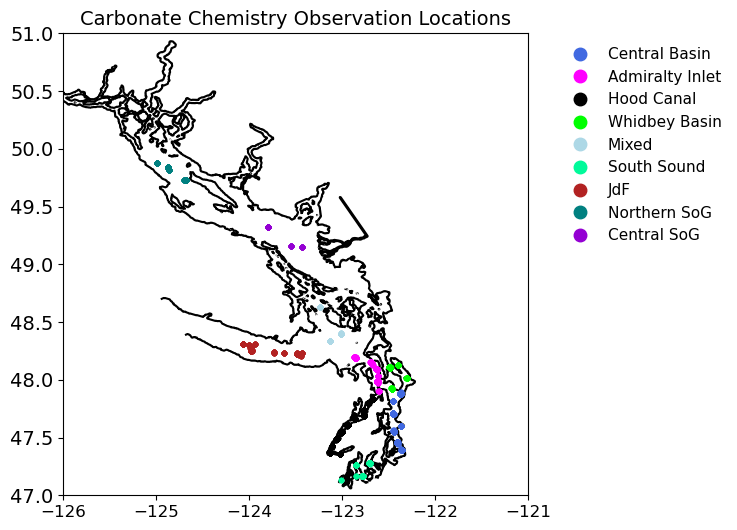

In [48]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_202108.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1,color='k')
colors=('royalblue',
'fuchsia','black',
'lime','lightblue','mediumspringgreen',
'firebrick',
        'teal',

'darkviolet',
 'deepskyblue','darkgoldenrod',

'black','green','darkorange','deepskyblue','darkgreen','darkblue','slateblue','purple')
datreg=dict()
for ind, iregion in enumerate(data.broadregions.dropna().unique()):
    datreg[iregion] = data.loc[data.broadregions==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 51)
plt.yticks(fontsize=12);
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -121)
plt.xticks(fontsize=12);
ax.set_title('Carbonate Chemistry Observation Locations');
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False,markerscale=3.,fontsize=11)
#fig.savefig('SalishSeaObservationLocations.jpg',bbox_inches='tight')

In [49]:
def byDepth(ax,obsvar,modvar,lims):
    SS=et.varvarPlot(ax,JdF,obsvar,modvar,'Z',(25,150),'z','m',('orange','darkturquoise','navy'))
    l=ax.legend(handles=SS)
    ax.set_xlabel('Observed Salinity (g kg-1)',fontsize=12)
    ax.set_ylabel('Matched Model Salinity (g kg-1)',fontsize=12)
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return SS,l

In [50]:
def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    SS=et.varvarPlot(ax[0],DJF,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Winter')
    SS=et.varvarPlot(ax[1],MAM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Spring')
    SS=et.varvarPlot(ax[2],JJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('Summer')
    SS=et.varvarPlot(ax[3],SON,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Autumn')
    return 

In [51]:
Hood.keys()

Index(['Cruise', 'dtUTC', 'Time', 'Lat', 'Lon', 'Z', 'Temp (degC)',
       'Temp (CT degC)', 'Sal (g kg-1)', 'Sal (PSS)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'TA (uM)', 'DIC (uM)', 'TA_FLAG',
       'DIC_FLAG', 'Unnamed: 0', 'ln', 'stn', 'mon', 'day', 'dic', 'alk',
       'OmegaA', 'obs_j', 'obs_i', 'Year', 'Month', 'YMO', 'j', 'i',
       'mod_dissolved_inorganic_carbon', 'mod_total_alkalinity',
       'mod_dissolved_oxygen', 'mod_votemper', 'mod_vosaline',
       'matched_salinity', 'pH_obs_mask', 'co2_obs_mask', 'pco2_obs_mask',
       'pH_mod_mask', 'co2_mod_mask', 'pco2_mod_mask', 'broadregions'],
      dtype='object')

## Compare CO2 and pCO2 with temperature, oxygen, and salinity in Hood Canal

Text(0.5, 1.0, '[CO2]')

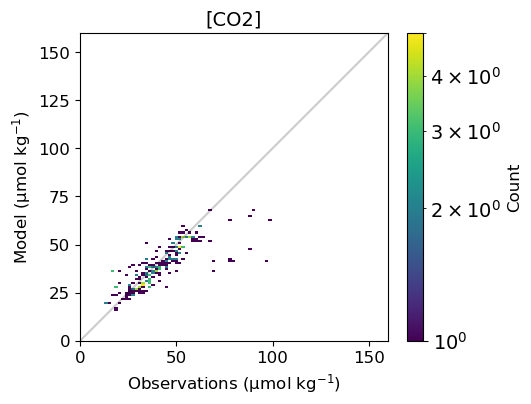

In [52]:
#[CO2]

fig,ax=plt.subplots(1,1,figsize=(5,4))
ii=(~np.isnan(JdF['co2_obs_mask']))&(~np.isnan(JdF['co2_mod_mask']))
counts, xedges, yedges, m1=ax.hist2d(((JdF.loc[ii,['co2_obs_mask']].values.flatten()+.001)),
                                      (JdF.loc[ii,['co2_mod_mask']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((0,160),(0,160),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(0,160)
ax.set_ylim(0,160)
plt.yticks(fontsize=12);
plt.xticks(fontsize=12);
ax.set_aspect(1)
ax.set_ylabel('Model (\u03bcmol kg$^{-1}$)',fontsize=12)
ax.set_xlabel('Observations (\u03bcmol kg$^{-1}$)',fontsize=12)
ax.set_title('[CO2]')
#ax.text(2300, 1600, 'WSS = 0.95', fontsize=10,  color='k',horizontalalignment='right', verticalalignment='center')
#ax.text(2300, 1550, 'Bias = 16.31', fontsize=10,  color='k',horizontalalignment='right', verticalalignment='center')
#ax.text(2300, 1500, 'RMSE = 40.87', fontsize=10,  color='k',horizontalalignment='right', verticalalignment='center')

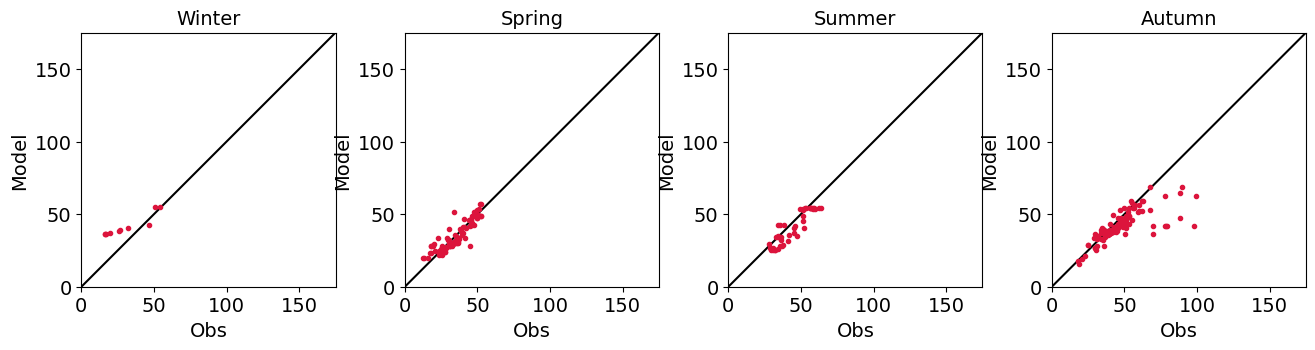

In [53]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'co2_obs_mask','co2_mod_mask',(0,175))

In [54]:
data.keys()

Index(['Cruise', 'dtUTC', 'Time', 'Lat', 'Lon', 'Z', 'Temp (degC)',
       'Temp (CT degC)', 'Sal (g kg-1)', 'Sal (PSS)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'TA (uM)', 'DIC (uM)', 'TA_FLAG',
       'DIC_FLAG', 'Unnamed: 0', 'ln', 'stn', 'mon', 'day', 'dic', 'alk',
       'OmegaA', 'obs_j', 'obs_i', 'Year', 'Month', 'YMO', 'j', 'i',
       'mod_dissolved_inorganic_carbon', 'mod_total_alkalinity',
       'mod_dissolved_oxygen', 'mod_votemper', 'mod_vosaline',
       'matched_salinity', 'pH_obs_mask', 'co2_obs_mask', 'pco2_obs_mask',
       'pH_mod_mask', 'co2_mod_mask', 'pco2_mod_mask', 'broadregions'],
      dtype='object')

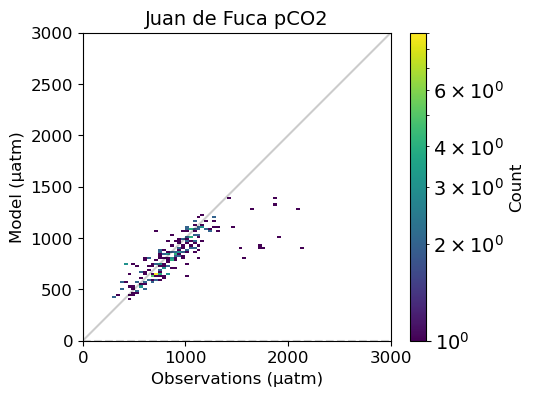

In [55]:
#pCO2

fig,ax=plt.subplots(1,1,figsize=(5,4))
ii=(~np.isnan(JdF['pco2_obs_mask']))&(~np.isnan(JdF['pco2_mod_mask']))
counts, xedges, yedges, m1=ax.hist2d((JdF.loc[ii,['pco2_obs_mask']].values.flatten()+.001),
                                      (JdF.loc[ii,['pco2_mod_mask']].values.flatten()+.001),bins=25*2,norm=LogNorm())


ax.plot((0,3000),(0,3000),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
plt.yticks(fontsize=12);
plt.xticks(fontsize=12);
ax.set_aspect(1)
ax.set_ylabel('Model (\u03bcatm)',fontsize=12)
ax.set_xlabel('Observations (\u03bcatm)',fontsize=12)
ax.set_title('Juan de Fuca pCO2')
ax.axvline(x=1,color='lightgrey',linestyle='--')
ax.axhline(y=1,color='lightgrey',linestyle='--')
#ax.text(3.75, 0.60, 'WSS = 0.79', fontsize=10,  color='k',horizontalalignment='right', verticalalignment='center')
#ax.text(3.75, 0.40, 'Bias = 0.17', fontsize=10,  color='k',horizontalalignment='right', verticalalignment='center')
#ax.text(3.75, 0.20, 'RMSE = 0.35', fontsize=10,  color='k',horizontalalignment='right', verticalalignment='center')

In [56]:
def byDepthHood(ax,obsvar,modvar,lims):
    SS=et.varvarPlot(ax,JdF,obsvar,modvar,'Z',(25,150),'z','m',('orange','darkturquoise','navy'))
    l=ax.legend(handles=SS)
    ax.set_xlabel('Observations',fontsize=12)
    ax.set_ylabel('Model',fontsize=12)
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return SS,l

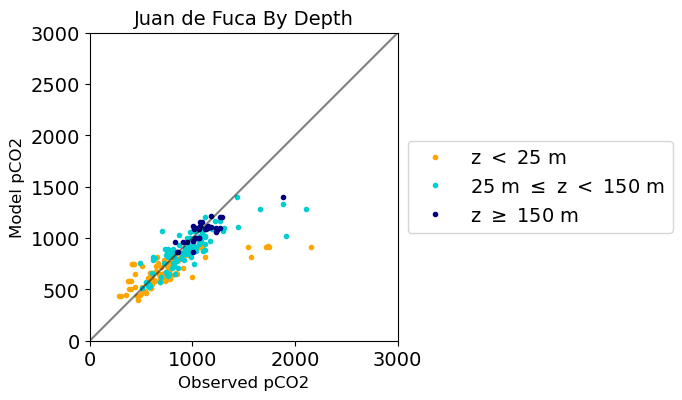

In [59]:
data=data
obsvar_JdF='pco2_obs_mask'
modvar_JdF='pco2_mod_mask'

fig, ax = plt.subplots(1,1,figsize = (4,4))
SS,l=byDepthHood(ax,obsvar_JdF,modvar_JdF,(0,3000))
ax.set_title('Juan de Fuca By Depth')
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_xlabel('Observed pCO2')
ax.set_ylabel('Model pCO2')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [60]:
Hood.keys()

Index(['Cruise', 'dtUTC', 'Time', 'Lat', 'Lon', 'Z', 'Temp (degC)',
       'Temp (CT degC)', 'Sal (g kg-1)', 'Sal (PSS)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'TA (uM)', 'DIC (uM)', 'TA_FLAG',
       'DIC_FLAG', 'Unnamed: 0', 'ln', 'stn', 'mon', 'day', 'dic', 'alk',
       'OmegaA', 'obs_j', 'obs_i', 'Year', 'Month', 'YMO', 'j', 'i',
       'mod_dissolved_inorganic_carbon', 'mod_total_alkalinity',
       'mod_dissolved_oxygen', 'mod_votemper', 'mod_vosaline',
       'matched_salinity', 'pH_obs_mask', 'co2_obs_mask', 'pco2_obs_mask',
       'pH_mod_mask', 'co2_mod_mask', 'pco2_mod_mask', 'broadregions'],
      dtype='object')

In [61]:

DJF = JdF['Month'].isin([12, 1, 2])
MAM = JdF['Month'].isin([3, 4, 5])
JJA = JdF['Month'].isin([6, 7, 8])
SON = JdF['Month'].isin([9, 10, 11])

In [62]:
print(DJF.shape)
print(Hood.shape)

(369,)
(1894, 47)


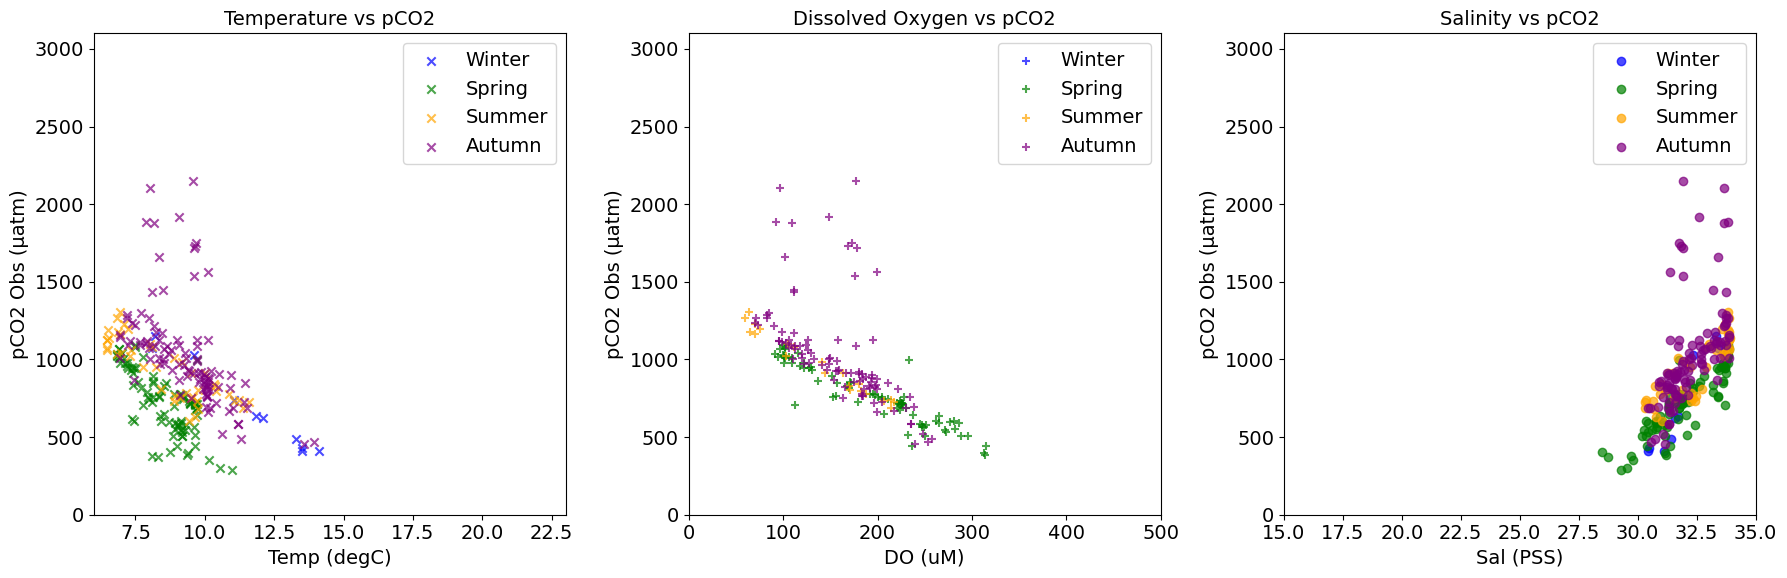

In [63]:
# Color and label for each season
season_dict = {
    'DJF': {'mask': DJF, 'color': 'blue', 'label': 'Winter'},
    'MAM': {'mask': MAM, 'color': 'green', 'label': 'Spring'},
    'JJA': {'mask': JJA, 'color': 'orange', 'label': 'Summer'},
    'SON': {'mask': SON, 'color': 'purple', 'label': 'Autumn'}
}

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
fig.tight_layout(pad=4)

# Temperature vs pCO2
for key, info in season_dict.items():
    JdF_season = JdF.loc[info['mask']]
    ax[0].scatter(JdF_season['Temp (degC)'], JdF_season['pco2_obs_mask'],
                  color=info['color'], label=info['label'], alpha=0.7, marker='x')

ax[0].set_ylim(0, 3100)
ax[0].set_xlim(6, 23)
ax[0].set_xlabel('Temp (degC)', fontsize=14)
ax[0].set_ylabel('pCO2 Obs (\u03bcatm)', fontsize=14)
ax[0].set_title('Temperature vs pCO2')
ax[0].legend()

# Dissolved Oxygen vs pCO2
for key, info in season_dict.items():
    JdF_season = JdF.loc[info['mask']]
    ax[1].scatter(JdF_season['DO (uM)'], JdF_season['pco2_obs_mask'],
                  color=info['color'], label=info['label'], alpha=0.7, marker='+')

ax[1].set_ylim(0, 3100)
ax[1].set_xlim(0, 500)
ax[1].set_xlabel('DO (uM)', fontsize=14)
ax[1].set_ylabel('pCO2 Obs (\u03bcatm)', fontsize=14)
ax[1].set_title('Dissolved Oxygen vs pCO2')
ax[1].legend()

# Salinity vs pCO2
for key, info in season_dict.items():
    JdF_season = JdF.loc[info['mask']]
    ax[2].scatter(JdF_season['Sal (PSS)'], JdF_season['pco2_obs_mask'],
                  color=info['color'], label=info['label'], alpha=0.7, marker='o')

ax[2].set_ylim(0, 3100)
ax[2].set_xlim(15, 35)
ax[2].set_xlabel('Sal (PSS)', fontsize=14)
ax[2].set_ylabel('pCO2 Obs (\u03bcatm)', fontsize=14)
ax[2].set_title('Salinity vs pCO2')
ax[2].legend()

plt.tight_layout()
plt.show()

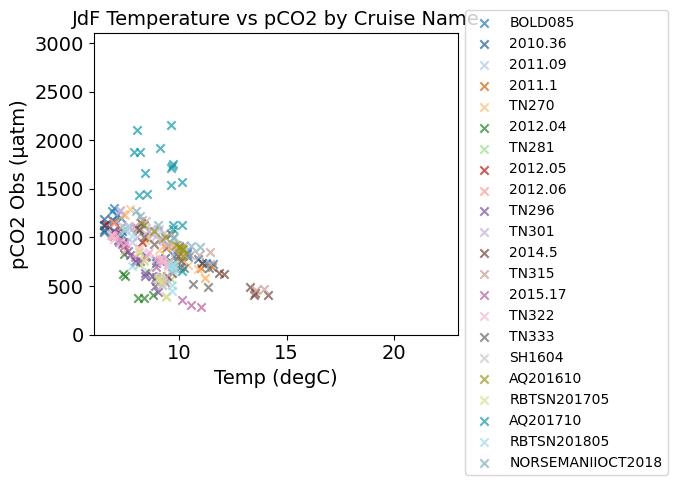

In [70]:
cruise_list = JdF['Cruise'].dropna().unique()

colors = plt.cm.tab20(np.linspace(0, 1, len(cruise_list)))
colors = [c if i % 2 == 0 else c * 0.8 for i, c in enumerate(colors)]  # Darker for even indices

# Create cruise dictionary
cruise_dict = {cruise: {'mask': JdF['Cruise'] == cruise,
                        'color': colors[i],
                        'label': cruise}
               for i, cruise in enumerate(cruise_list)}
                                          
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
fig.tight_layout(pad=4)

# Temperature vs pCO2
for key, info in cruise_dict.items():
    JdF_cruise = JdF.loc[info['mask']]
    ax.scatter(JdF_cruise['Temp (degC)'], JdF_cruise['pco2_obs_mask'],
                  color=info['color'], label=info['label'], alpha=0.7, marker='x')

ax.set_ylim(0, 3100)
ax.set_xlim(6, 23)
ax.set_xlabel('Temp (degC)', fontsize=14)
ax.set_ylabel('pCO2 Obs (\u03bcatm)', fontsize=14)
ax.set_title('JdF Temperature vs pCO2 by Cruise Name')
ax.legend(bbox_to_anchor=(1.0, 1.1), loc='upper left',fontsize=10)


plt.tight_layout()
plt.show()

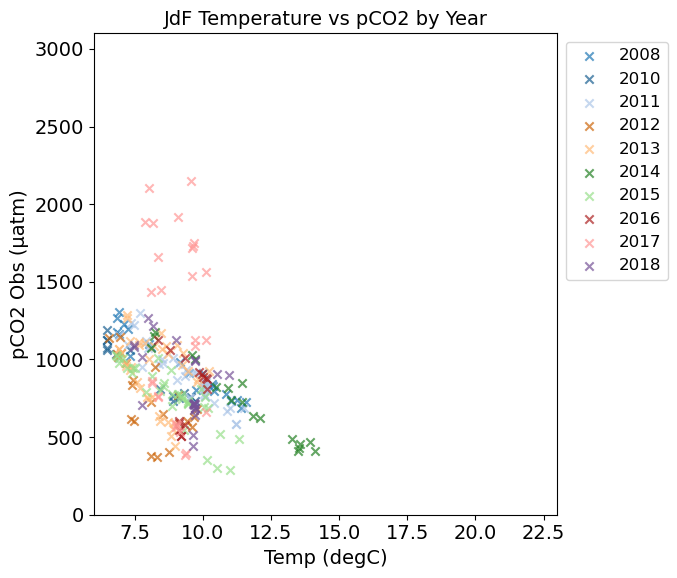

In [71]:
year_list = JdF['Year'].dropna().unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(cruise_list)))
colors = [c if i % 2 == 0 else c * 0.8 for i, c in enumerate(colors)]  # Darker for even indices

# Create cruise dictionary
year_dict = {year: {'mask': JdF['Year'] == year,
                        'color': colors[i],
                        'label': year}
               for i, year in enumerate(year_list)}

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
fig.tight_layout(pad=4)

# Temperature vs pCO2
for key, info in year_dict.items():
    JdF_year = JdF.loc[info['mask']]
    ax.scatter(JdF_year['Temp (degC)'], JdF_year['pco2_obs_mask'],
                  color=info['color'], label=info['label'], alpha=0.7, marker='x')

ax.set_ylim(0, 3100)
ax.set_xlim(6, 23)
ax.set_xlabel('Temp (degC)', fontsize=14)
ax.set_ylabel('pCO2 Obs (\u03bcatm)', fontsize=14)
ax.set_title('JdF Temperature vs pCO2 by Year')
ax.legend(bbox_to_anchor=(1.0, 1), loc='upper left',fontsize=12)


plt.tight_layout()
plt.show()
